# EXERCISES 11

In [126]:
import numpy as np
from matplotlib import pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import chi2

## Exercise 11.1
After defining, in a dedicated library, a linear function 
 with two parameters 
:

Write a program that generates a set of 10 pairs 
 such that the points 
 are randomly distributed along the horizontal axis between 0 and 10, and the points 
 are constructed using the formula 
.

Plot the obtained sample, including the expected error bars.




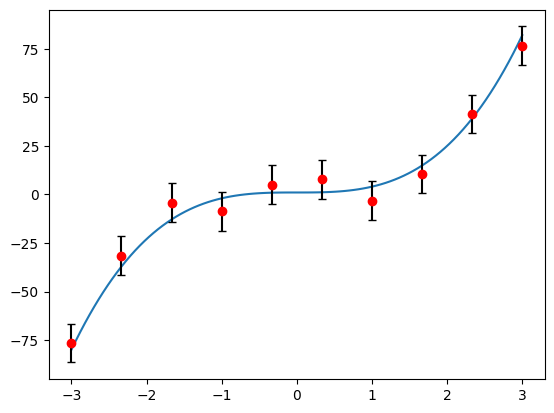

In [90]:
def phi(x,t1,t2):
    return t1 + t2*x**3

expT = [1,3]
expX = np.linspace(-3,3,100)
expY = phi(expX, *expT)
sigma = 10

N = 10
realX = np.linspace(-3,3,N)
epsilon = (np.random.rand(N)*2 - 1) * sigma
P = phi(realX, *expT)
realY = P + epsilon

plt.plot(expX,expY)
plt.errorbar(realX,realY,yerr=sigma,fmt='o',color='red',ecolor='black',capsize=3)
plt.show()


## Exercise 11.2
Use the iMinuit library to perform a fit on the simulated sample.

Check if the fit was successful.

Print the values of the determined parameters and their sigmas on the screen.

In [115]:
least_squares = LeastSquares (realX, realY, sigma*np.ones(N), phi)
my_minuit = Minuit (least_squares, t1 = 1, t2 = 3)  # starting values for t1 and t2
my_minuit.migrad ()  # finds minimum of least_squares function
my_minuit.hesse ()   # accurately computes uncertainties
print(my_minuit)

is_valid = my_minuit.valid
print ('success of the fit: ', is_valid)
Q_squared = my_minuit.fval
print ('value of the fit Q-squared', Q_squared)
N_dof = my_minuit.ndof
print ('value of the number of degrees of freedom', N_dof)

for par, val, err in zip (my_minuit.parameters, my_minuit.values, my_minuit.errors) :
    print(f'{par} = {val:.3f} +/- {err:.3f}') # formatted output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.631 (χ²/ndof = 0.3)      │              Nfcn = 32               │
│ EDM = 1.96e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

## Exercise 11.3
Calculate the value of $Q^2$
 using the points and the fitted function obtained in the previous exercise.

Compare the value obtained with iminuit with the calculated one.

Print the value of the degrees of freedom of the fit.

In [98]:
Q2 = np.sum(((realY - phi(realX,*expT))/sigma)**2)

print(f'Q2: {Q2}, minuit Q2: {my_minuit.fval}')

Q2: 3.3369643853073456, minuit Q2: 2.6306116344067267


## Exercise 11.4
Using the toy experiments technique, generate 10,000 fit experiments with the model studied in the previous exercises and fill a histogram with the obtained values of $Q^2$.

Compare the expected value of  $Q^2$
 obtained from the toy experiments with the degrees of freedom of the problem.

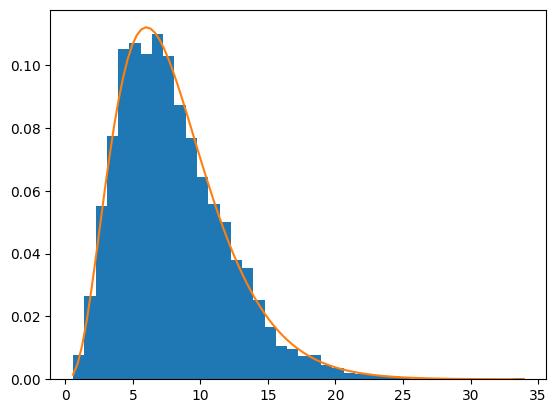

7.96276563200063 812.4868987071366


In [168]:
def toy_exp_Q(phi,sigma,N): # parameters of phy are fixed
    realX = np.random.rand(N) * 6 - 3 # rand number [-3,3]
    
    expY = phi(realX,1,3)
    epsilon = np.random.normal(loc=0,scale=sigma,size=N)
    realY = expY + epsilon
    
    least_squares = LeastSquares (realX, realY, sigma*np.ones(N), phi)
    fit = Minuit (least_squares, t1 = 1, t2 = 3)
    fit.migrad ()
    return np.sum(((realY - phi(realX,fit.values[0],fit.values[1]))/sigma)**2)

N = 10
k = 2
t1, t2 = 1, 3
sigma = 10
Q2S = np.array([toy_exp_Q(phi,sigma,N) for i in range(5000)])


plt.hist(Q2S,bins=40,density=True)
x = np.linspace(min(Q2S),max(Q2S),100)
plt.plot(x,chi2.pdf(x,df=10-2))
plt.show()

mean = np.average(Q2S)
variance = np.sum(((Q2S - mean)/sigma)**2)

print(mean,variance)

## Exercise 11.5
Modify the previous program by deliberately changing the experimental uncertainty associated with the points $y_i$ in the sample and verify that it’s possible to recover the uncertainty used in generating the points through the expected value of the variable $Q^2$.

$E(Q^2) = E(\Chi^2(Q^2,N-k)) = N - k$

$E(V(Q^2)) = E(V(\Chi^2(Q^2,N-k))) = 2(N-k)$

$V(Q^2) = \sum (\frac{Q^2 - \bar{Q^2}}{\sigma})^2$

$\sigma^2 = \frac{\sum (Q^2 - N + k)^2}{2(N-k)}$

In [165]:
def toy_exp_Q(phi,sigma,N): # parameters of phy are fixed
    realX = np.random.rand(N) * 6 - 3 # rand number [-3,3]
    
    expY = phi(realX,1,3)
    epsilon = np.random.normal(loc=0,scale=sigma,size=N)
    realY = expY + epsilon
    
    least_squares = LeastSquares (realX, realY, sigma*np.ones(N), phi)
    fit = Minuit (least_squares, t1 = 1, t2 = 3)
    fit.migrad ()
    return np.sum(((realY - phi(realX,fit.values[0],fit.values[1]))/sigma)**2)

N = 10
k = 2
t1, t2 = 1, 3

Q2S = np.array([np.array([toy_exp_Q(phi,sigma,N) for i in range(100)]) for sigma in range(10,60,10)])

sigmas = np.sqrt(np.array([np.sum((Q2S[i] - N + k)**2) for i in range(0,len(Q2S))]))

print(sigmas)


# plt.hist(Q2S,bins=40,density=True)
# x = np.linspace(min(Q2S),max(Q2S),100)
# plt.plot(x,chi2.pdf(x,df=10-2))
# plt.show()

# mean = np.average(Q2S)
# variance = np.sum(((Q2S - mean)/sigma)**2)

# print(mean,variance)

[35.10069353 34.80266411 38.7611912  42.10164159 38.49470335]
